<a href="https://colab.research.google.com/github/DannMacias/corn-leaf-disease-detection/blob/main/02_data_augmentation_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Data Augmentation Experiments </b>

The goal of this notebook is to test different data augmentation techniques to increase the performance of the model (EfficientNet B2).

Six different transformations will be tested:
* [Color Jitter](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter);
* [Gaussian Blur](https://pytorch.org/vision/stable/generated/torchvision.transforms.GaussianBlur.html#gaussianblur);
* [Random Invert](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomInvert.html#randominvert);
* [RandAugment](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandAugment.html#randaugment);
* [TrivialAugmentWide](https://pytorch.org/vision/stable/generated/torchvision.transforms.TrivialAugmentWide.html#trivialaugmentwide);
* [AugMix](https://pytorch.org/vision/stable/generated/torchvision.transforms.AugMix.html#augmix).


At the end, the six transformations, plus a control (no data augmentation), will be compared and the transformation that produces the best performance (accuracy greater than 90%) will be chosen.

# 0. Getting setup

In [ ]:
# Import dependencies
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Check for GPU in Google Colab
!nvidia-smi

Mon Feb 20 19:15:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get helper functions (for training and make predictions) from GitHub repo
# See https://github.com/DannMacias/corn-leaf-disease-detection
# Clone the repo
!git clone https://github.com/DannMacias/corn-leaf-disease-detection

# Move the folder helper_functions
!mv corn-leaf-disease-detection/helper_functions .

# Remove the remaining files from the repo of Google Colab
!rm -rf corn-leaf-disease-detection
from helper_functions import engine, predictions, utils

Cloning into 'corn-leaf-disease-detection'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 53 (delta 19), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (53/53), 1.77 MiB | 5.80 MiB/s, done.


# 1. Get the data

In [ ]:
# Get the data from Google Drive
!unzip /content/drive/MyDrive/Pytorch_notes/corn-leaf-image-classification/corn-leaf-disease.zip > /dev/null

In [ ]:
data_path = "/content/data"

In [ ]:
# Download and import splitfolders
!pip install split-folders
import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Split the data in train (80%) and test (20%)
splitfolders.ratio(input = data_path,
                   output = "splitted_data",
                   seed = 42,
                   ratio = (0.8, 0.2),
                   group_prefix = None,
                   move = False)

Copying files: 4188 files [00:01, 3892.65 files/s]


In [ ]:
# Setup train and test directories
train_dir = "/content/splitted_data/train"
test_dir = "/content/splitted_data/val"

train_dir, test_dir

('/content/splitted_data/train', '/content/splitted_data/val')

# 2. Create DataLoaders

## 2.1. Create a function to make DataLoaders

In [ ]:
import os
NUM_WORKERS = os.cpu_count()

def create_train_dataloader(train_dir: str,
                            train_transform: transforms.Compose,
                            batch_size: int,
                            num_workers: int = NUM_WORKERS):
  
  # Use ImageFolder to create datasets
  train_data = datasets.ImageFolder(train_dir, transform = train_transform)

  # Turn datasets into DataLoaders
  train_dataloader = DataLoader(
      train_data,
      batch_size = batch_size,
      shuffle = True,
      num_workers = num_workers,
      pin_memory = True
  )
  return train_dataloader

## 2.2. Create different transforms for data augmentation

### Simple transforms

In [ ]:
# Normalization
Normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                     std = [0.229, 0.224, 0.225])

# Simple transforms, no data augmentation
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    Normalize
])

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
LEARNING_RATE = 0.001

In [ ]:
# Test DataLoader
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = simple_transform)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False,
                             num_workers = NUM_WORKERS,
                             pin_memory = True)

In [ ]:
# Get the class names
class_names = test_data.classes
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [ ]:
# Create DataLoaders without data augmentation
train_no_aug_dataloader = create_train_dataloader(train_dir = train_dir,
                                                  train_transform = simple_transform,
                                                  batch_size = BATCH_SIZE,
                                                  num_workers = NUM_WORKERS)

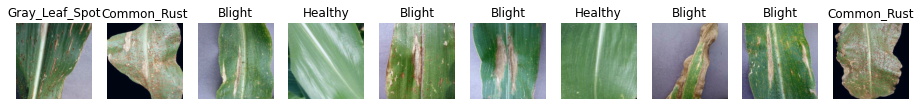

In [ ]:
# Visualize the images in the DataLoader without data augmentation
utils.view_dataloader_images(dataloader = train_no_aug_dataloader,
                             class_names = class_names,
                             num_images = 10)

### ColorJitter

The `ColorJitter` transform randomly changes the brightness, saturation, and other properties of an image.

In [ ]:
# ColorJitter
colorjitter_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness = 0.5, hue = 0.3),
    transforms.ToTensor(),
    Normalize
])

In [ ]:
# Create DataLoaders with ColorJitter
train_colorjitter_dataloader = create_train_dataloader(train_dir = train_dir,
                                                       train_transform = colorjitter_transform,
                                                       batch_size = BATCH_SIZE,
                                                       num_workers = NUM_WORKERS)

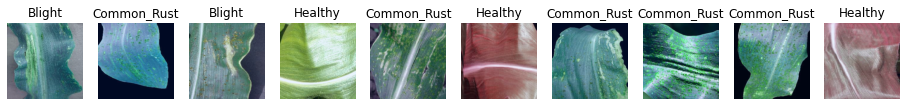

In [ ]:
# Visualize the images in the DataLoader with ColorJitter
utils.view_dataloader_images(dataloader = train_colorjitter_dataloader,
                             class_names = class_names,
                             num_images = 10)

### Gaussian Blur

Performs gaussian blur transform on an image.

In [ ]:
# Gaussian Blur
gaussianblur_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(kernel_size = (5, 9), sigma = (0.1, 5)),
    transforms.ToTensor(),
    Normalize
])

In [ ]:
# Create DataLoaders with Gaussian Blur
train_gaussianblur_dataloader = create_train_dataloader(train_dir = train_dir,
                                                       train_transform = gaussianblur_transform,
                                                       batch_size = BATCH_SIZE,
                                                       num_workers = NUM_WORKERS)

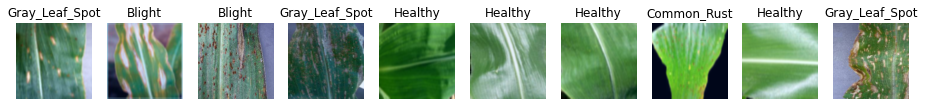

In [ ]:
# Visualize the images in the DataLoader with Gaussian Blur
utils.view_dataloader_images(dataloader = train_gaussianblur_dataloader,
                             class_names = class_names,
                             num_images = 10)

### Random Invert

Randomly inverts the colors of the given image.

In [ ]:
# RandomInvert
randominvert_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomInvert(p = 0.3), # default is 0.5
    transforms.ToTensor(),
    Normalize
])

# Create DataLoaders with RandomInvert
train_randominvert_dataloader = create_train_dataloader(train_dir = train_dir,
                                                       train_transform = randominvert_transform,
                                                       batch_size = BATCH_SIZE,
                                                       num_workers = NUM_WORKERS)

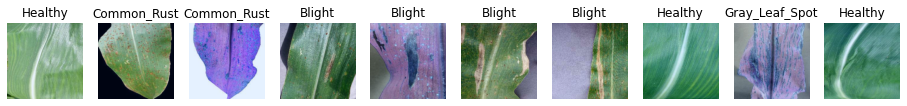

In [ ]:
# Visualize the images in the DataLoader with RandomInvert
utils.view_dataloader_images(dataloader = train_randominvert_dataloader,
                             class_names = class_names,
                             num_images = 10)

### RandAugment

Automatically augments the data.

In [ ]:
# RandomAugment
randaugment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandAugment(),
    transforms.ToTensor(),
    Normalize
])

# Create DataLoaders with RandomAugment
train_randaugment_dataloader = create_train_dataloader(train_dir = train_dir,
                                                       train_transform = randaugment_transform,
                                                       batch_size = BATCH_SIZE,
                                                       num_workers = NUM_WORKERS)

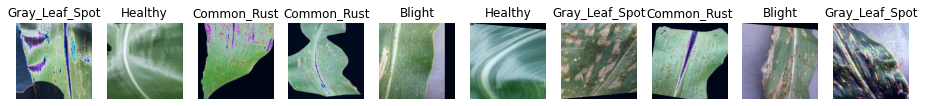

In [ ]:
# Visualize the images in the DataLoader with RandomAugment
utils.view_dataloader_images(dataloader = train_randaugment_dataloader,
                             class_names = class_names,
                             num_images = 10)

### TrivialAugmentWide

Automatically augments the data.

In [ ]:
# TrivialAugmentWide
trivialaugmentwide_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    Normalize
])

# Create DataLoaders with TrivialAugmentWide
train_trivialaugmentwide_dataloader = create_train_dataloader(train_dir = train_dir,
                                                       train_transform = trivialaugmentwide_transform,
                                                       batch_size = BATCH_SIZE,
                                                       num_workers = NUM_WORKERS)

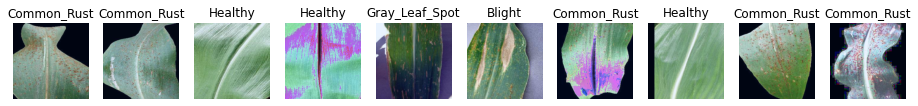

In [ ]:
# Visualize the images in the DataLoader with TrivialAugmentWide
utils.view_dataloader_images(dataloader = train_trivialaugmentwide_dataloader,
                             class_names = class_names,
                             num_images = 10)

### AugMix

Automatically augments the data.

In [ ]:
# AugMix
augmix_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.AugMix(),
    transforms.ToTensor(),
    Normalize
])

# Create DataLoaders with AugMix
train_augmix_dataloader = create_train_dataloader(train_dir = train_dir,
                                                       train_transform = augmix_transform,
                                                       batch_size = BATCH_SIZE,
                                                       num_workers = NUM_WORKERS)

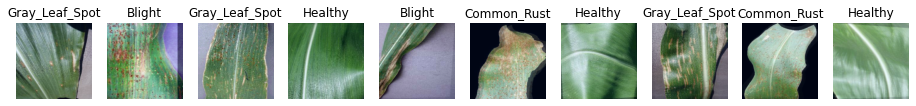

In [ ]:
# Visualize the images in the DataLoader with AugMix
utils.view_dataloader_images(dataloader = train_augmix_dataloader,
                             class_names = class_names,
                             num_images = 10)

# 3. Training

EfficientNetB2 will be used as a model

In [ ]:
# Ussing EffNetbB2
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights = weights)

# Freeze all the layers in base model
for param in effnetb2.parameters():
  param.requires_grad = False

# Change the classifier head
torch.manual_seed(42)
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=4,
              bias=True)
)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [ ]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr = LEARNING_RATE)

## Train the model (No augmentation)

In [ ]:
# Train the model
no_aug_results = engine.train(model = effnetb2,
                              train_dataloader = train_no_aug_dataloader,
                              test_dataloader = test_dataloader,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              epochs = 10,
                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6133 | train_acc: 0.8048 | test_loss: 0.3757 | test_acc: 0.8715
Epoch: 2 | train_loss: 0.3304 | train_acc: 0.8895 | test_loss: 0.3096 | test_acc: 0.8796
Epoch: 3 | train_loss: 0.2873 | train_acc: 0.8989 | test_loss: 0.2808 | test_acc: 0.8900
Epoch: 4 | train_loss: 0.2535 | train_acc: 0.9077 | test_loss: 0.2654 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.2435 | train_acc: 0.9134 | test_loss: 0.2519 | test_acc: 0.8993
Epoch: 6 | train_loss: 0.2334 | train_acc: 0.9117 | test_loss: 0.2548 | test_acc: 0.8993
Epoch: 7 | train_loss: 0.2244 | train_acc: 0.9164 | test_loss: 0.2504 | test_acc: 0.8993
Epoch: 8 | train_loss: 0.2212 | train_acc: 0.9208 | test_loss: 0.2386 | test_acc: 0.9109
Epoch: 9 | train_loss: 0.2157 | train_acc: 0.9208 | test_loss: 0.2390 | test_acc: 0.9062
Epoch: 10 | train_loss: 0.2076 | train_acc: 0.9229 | test_loss: 0.2389 | test_acc: 0.9005


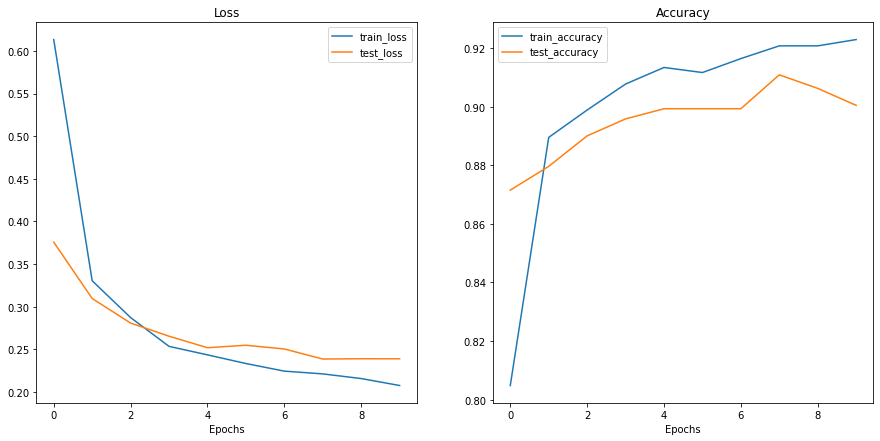

In [ ]:
# Plot loss curves 
utils.plot_loss_curves(no_aug_results)

I will save the results of the last epoch in a dictionary to compare the loss value an the accuracy of the different transformations.

In [ ]:
# Create no_aug statistics dictionary
no_aug_stats = {"test_loss": no_aug_results["test_loss"][-1],
                "test_acc": no_aug_results["test_acc"][-1]}

no_aug_stats

{'test_loss': 0.23893007294585308, 'test_acc': 0.9004629629629629}

## Train the model (Color Jitter)

In [ ]:
# Train the model (Color Jitter)
colorjitter_results = engine.train(model = effnetb2,
                              train_dataloader = train_colorjitter_dataloader,
                              test_dataloader = test_dataloader,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              epochs = 10,
                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3538 | train_acc: 0.8666 | test_loss: 0.2412 | test_acc: 0.9016
Epoch: 2 | train_loss: 0.3022 | train_acc: 0.8906 | test_loss: 0.2470 | test_acc: 0.9051
Epoch: 3 | train_loss: 0.2746 | train_acc: 0.8871 | test_loss: 0.2428 | test_acc: 0.9086
Epoch: 4 | train_loss: 0.2982 | train_acc: 0.8870 | test_loss: 0.2445 | test_acc: 0.9109
Epoch: 5 | train_loss: 0.2860 | train_acc: 0.8883 | test_loss: 0.2431 | test_acc: 0.9051
Epoch: 6 | train_loss: 0.2856 | train_acc: 0.8940 | test_loss: 0.2414 | test_acc: 0.9086
Epoch: 7 | train_loss: 0.2651 | train_acc: 0.8946 | test_loss: 0.2414 | test_acc: 0.9074
Epoch: 8 | train_loss: 0.2878 | train_acc: 0.8905 | test_loss: 0.2514 | test_acc: 0.9039
Epoch: 9 | train_loss: 0.2721 | train_acc: 0.8912 | test_loss: 0.2481 | test_acc: 0.8993
Epoch: 10 | train_loss: 0.2776 | train_acc: 0.8911 | test_loss: 0.2500 | test_acc: 0.8970


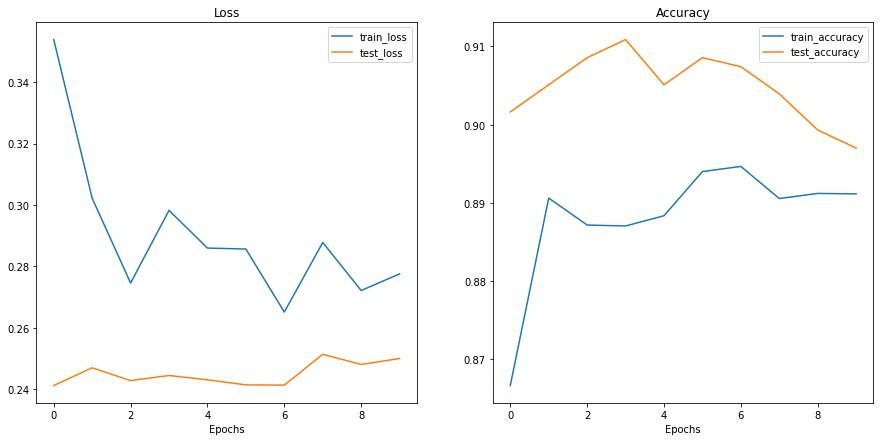

In [ ]:
# Plot loss curves 
utils.plot_loss_curves(colorjitter_results)

Accuracy is 90% on average in the test set, in addition to having a loss of 0.26. However, for the train set, the accuracy was not higher than 89% and the loss values were higher than those of the test set.

The results are worse than the control.

In [ ]:
# Create colorjitter statistics dictionary
colorjitter_stats = {"test_loss": colorjitter_results["test_loss"][-1],
                "test_acc": colorjitter_results["test_acc"][-1]}

colorjitter_stats

{'test_loss': 0.25003564902753744, 'test_acc': 0.8969907407407407}

## Train the model (Gaussian Blur)

In [ ]:
# Train the model (Gaussian Blur)
gaussblur_results = engine.train(model = effnetb2,
                              train_dataloader = train_gaussianblur_dataloader,
                              test_dataloader = test_dataloader,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              epochs = 10,
                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3500 | train_acc: 0.8662 | test_loss: 0.8032 | test_acc: 0.6748
Epoch: 2 | train_loss: 0.3019 | train_acc: 0.8835 | test_loss: 0.7159 | test_acc: 0.6933
Epoch: 3 | train_loss: 0.3022 | train_acc: 0.8817 | test_loss: 0.4717 | test_acc: 0.8125
Epoch: 4 | train_loss: 0.2788 | train_acc: 0.8886 | test_loss: 0.5087 | test_acc: 0.7975
Epoch: 5 | train_loss: 0.2733 | train_acc: 0.8907 | test_loss: 0.5608 | test_acc: 0.7720
Epoch: 6 | train_loss: 0.2662 | train_acc: 0.8992 | test_loss: 0.4390 | test_acc: 0.8299
Epoch: 7 | train_loss: 0.2512 | train_acc: 0.9055 | test_loss: 0.4169 | test_acc: 0.8438
Epoch: 8 | train_loss: 0.2552 | train_acc: 0.8992 | test_loss: 0.5465 | test_acc: 0.7847
Epoch: 9 | train_loss: 0.2457 | train_acc: 0.9012 | test_loss: 0.4098 | test_acc: 0.8414
Epoch: 10 | train_loss: 0.2554 | train_acc: 0.9027 | test_loss: 0.4119 | test_acc: 0.8461


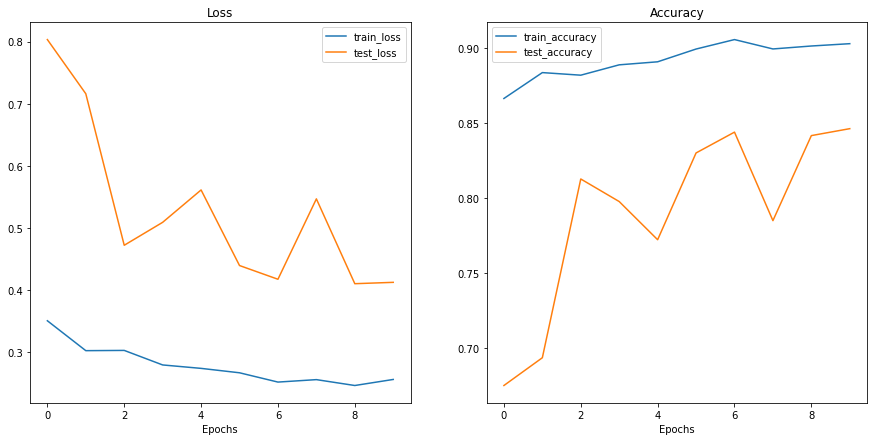

In [ ]:
# Plot loss curves 
utils.plot_loss_curves(gaussblur_results)

Accuray is greater than 90% in the train set, but less than 85% in the test set. The loss curves shows that the model is overfitting.

In [ ]:
# Create Gaussian Blur statistics dictionary
gaussblur_stats = {"test_loss": gaussblur_results["test_loss"][-1],
                 "test_acc": gaussblur_results["test_acc"][-1]}

gaussblur_stats

{'test_loss': 0.41194984171953464, 'test_acc': 0.8460648148148148}

## Train the model (RandomInvert)

In [ ]:
# Train the model (RandomInvert)
randinv_results = engine.train(model = effnetb2,
                              train_dataloader = train_randominvert_dataloader,
                              test_dataloader = test_dataloader,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              epochs = 10,
                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3169 | train_acc: 0.8767 | test_loss: 0.2294 | test_acc: 0.9016
Epoch: 2 | train_loss: 0.2845 | train_acc: 0.8861 | test_loss: 0.2327 | test_acc: 0.9051
Epoch: 3 | train_loss: 0.2645 | train_acc: 0.8986 | test_loss: 0.2332 | test_acc: 0.9005
Epoch: 4 | train_loss: 0.2591 | train_acc: 0.8958 | test_loss: 0.2309 | test_acc: 0.9016
Epoch: 5 | train_loss: 0.2668 | train_acc: 0.8990 | test_loss: 0.2357 | test_acc: 0.9005
Epoch: 6 | train_loss: 0.2289 | train_acc: 0.9129 | test_loss: 0.2300 | test_acc: 0.9028
Epoch: 7 | train_loss: 0.2378 | train_acc: 0.9101 | test_loss: 0.2344 | test_acc: 0.9039
Epoch: 8 | train_loss: 0.2451 | train_acc: 0.9049 | test_loss: 0.2284 | test_acc: 0.9039
Epoch: 9 | train_loss: 0.2380 | train_acc: 0.9092 | test_loss: 0.2360 | test_acc: 0.9028
Epoch: 10 | train_loss: 0.2240 | train_acc: 0.9169 | test_loss: 0.2373 | test_acc: 0.9028


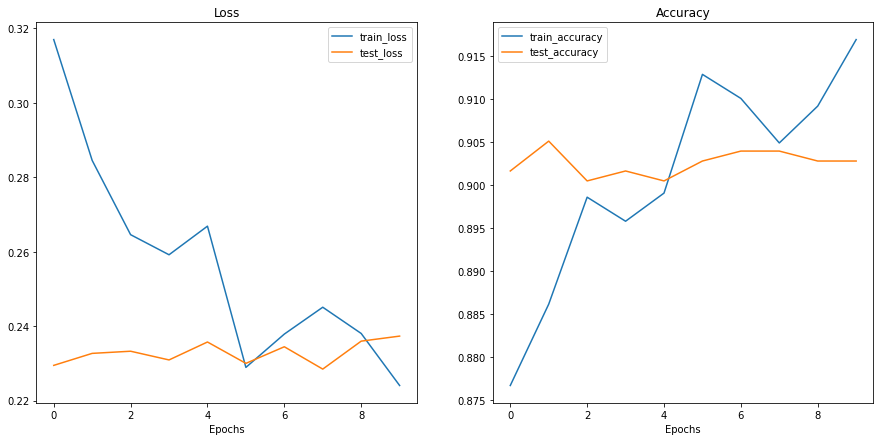

In [ ]:
# Plot loss curves 
utils.plot_loss_curves(randinv_results)

The accuracy of the test set is less than 91%. The loss curves shows the absence of overfitting or underfitting. This transformation gives better results than the control.

In [ ]:
# Create RandomInvert statistics dictionary
randinv_stats = {"test_loss": randinv_results["test_loss"][-1],
                 "test_acc": randinv_results["test_acc"][-1]}

randinv_stats

{'test_loss': 0.23730555412152576, 'test_acc': 0.9027777777777778}

## Train the model (RandAugment)

In [ ]:
# Train the model (RandAugment)
randaug_results = engine.train(model = effnetb2,
                              train_dataloader = train_randaugment_dataloader,
                              test_dataloader = test_dataloader,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              epochs = 10,
                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2708 | train_acc: 0.8926 | test_loss: 0.2064 | test_acc: 0.9155
Epoch: 2 | train_loss: 0.2850 | train_acc: 0.8897 | test_loss: 0.2034 | test_acc: 0.9178
Epoch: 3 | train_loss: 0.2557 | train_acc: 0.9002 | test_loss: 0.2023 | test_acc: 0.9178
Epoch: 4 | train_loss: 0.2548 | train_acc: 0.9048 | test_loss: 0.2036 | test_acc: 0.9144
Epoch: 5 | train_loss: 0.2527 | train_acc: 0.9036 | test_loss: 0.2049 | test_acc: 0.9132
Epoch: 6 | train_loss: 0.2513 | train_acc: 0.9015 | test_loss: 0.1972 | test_acc: 0.9213
Epoch: 7 | train_loss: 0.2555 | train_acc: 0.8995 | test_loss: 0.1992 | test_acc: 0.9190
Epoch: 8 | train_loss: 0.2407 | train_acc: 0.9139 | test_loss: 0.1996 | test_acc: 0.9144
Epoch: 9 | train_loss: 0.2500 | train_acc: 0.9060 | test_loss: 0.1994 | test_acc: 0.9225
Epoch: 10 | train_loss: 0.2397 | train_acc: 0.9080 | test_loss: 0.2003 | test_acc: 0.9190


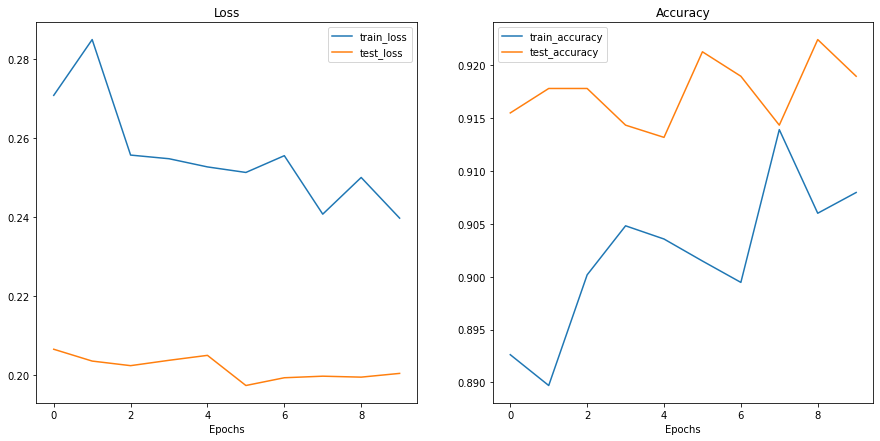

In [ ]:
# Plot loss curves 
utils.plot_loss_curves(randaug_results)

Accuracy in the test set is greater than 91% althought for the train set, it is lower (89%). The loss cruves show very low loss values for the test set (0.2) comapred to the train set (+0.25).

In [ ]:
# Create RandAugment statistics dictionary
randaug_stats = {"test_loss": randaug_results["test_loss"][-1],
                            "test_acc": randaug_results["test_acc"][-1]}

randaug_stats

{'test_loss': 0.20031350549241458, 'test_acc': 0.9189814814814815}

## Train the model (TrivialAugmentWide)

In [ ]:
# Train the model (TrivialAugmentWide)
trivialaugmentwide_results = engine.train(model = effnetb2,
                              train_dataloader = train_trivialaugmentwide_dataloader,
                              test_dataloader = test_dataloader,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              epochs = 10,
                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2699 | train_acc: 0.8947 | test_loss: 0.1984 | test_acc: 0.9225
Epoch: 2 | train_loss: 0.2851 | train_acc: 0.8927 | test_loss: 0.2000 | test_acc: 0.9248
Epoch: 3 | train_loss: 0.2730 | train_acc: 0.8960 | test_loss: 0.2000 | test_acc: 0.9190
Epoch: 4 | train_loss: 0.2604 | train_acc: 0.9002 | test_loss: 0.1926 | test_acc: 0.9306
Epoch: 5 | train_loss: 0.2489 | train_acc: 0.9062 | test_loss: 0.1931 | test_acc: 0.9236
Epoch: 6 | train_loss: 0.2664 | train_acc: 0.9024 | test_loss: 0.1915 | test_acc: 0.9282
Epoch: 7 | train_loss: 0.2761 | train_acc: 0.8905 | test_loss: 0.1940 | test_acc: 0.9236
Epoch: 8 | train_loss: 0.2624 | train_acc: 0.8919 | test_loss: 0.2011 | test_acc: 0.9259
Epoch: 9 | train_loss: 0.2565 | train_acc: 0.8985 | test_loss: 0.1991 | test_acc: 0.9167
Epoch: 10 | train_loss: 0.2690 | train_acc: 0.8997 | test_loss: 0.2005 | test_acc: 0.9236


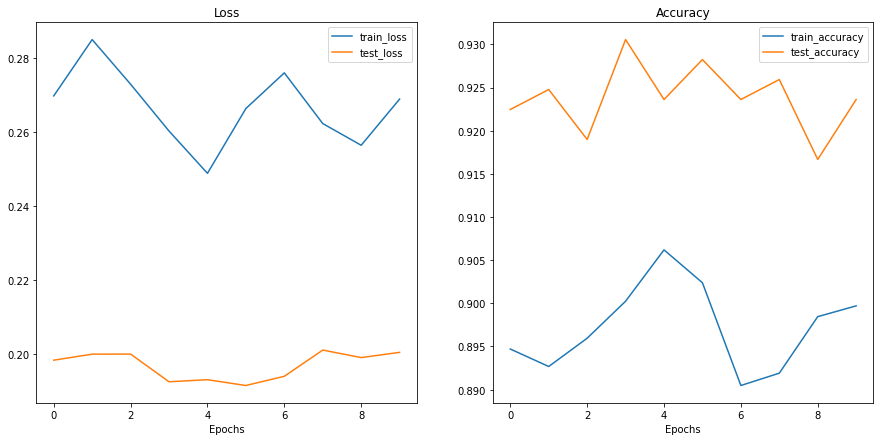

In [ ]:
# Plot loss curves 
utils.plot_loss_curves(trivialaugmentwide_results)

The results are similar to those obtained with the RandAugment transformation, with a higher loss in the train set (+0.26) compared to the test set (0.20).

In [ ]:
# Create TrivialAugmentWide statistics dictionary
trivialaugmentwide_stats = {"test_loss": trivialaugmentwide_results["test_loss"][-1],
                            "test_acc": trivialaugmentwide_results["test_acc"][-1]}

trivialaugmentwide_stats

{'test_loss': 0.20050314325339127, 'test_acc': 0.9236111111111112}

## Train the model (AugMix)

In [ ]:
# Train the model (Aug Mix)
augmix_results = engine.train(model = effnetb2,
                              train_dataloader = train_augmix_dataloader,
                              test_dataloader = test_dataloader,
                              optimizer = optimizer,
                              loss_fn = loss_fn,
                              epochs = 10,
                              device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2402 | train_acc: 0.9089 | test_loss: 0.2297 | test_acc: 0.9005
Epoch: 2 | train_loss: 0.2160 | train_acc: 0.9173 | test_loss: 0.2159 | test_acc: 0.9097
Epoch: 3 | train_loss: 0.2222 | train_acc: 0.9141 | test_loss: 0.2116 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.2309 | train_acc: 0.9152 | test_loss: 0.2158 | test_acc: 0.9155
Epoch: 5 | train_loss: 0.2182 | train_acc: 0.9164 | test_loss: 0.2192 | test_acc: 0.9097
Epoch: 6 | train_loss: 0.2268 | train_acc: 0.9128 | test_loss: 0.2181 | test_acc: 0.9086
Epoch: 7 | train_loss: 0.2379 | train_acc: 0.9081 | test_loss: 0.2154 | test_acc: 0.9132
Epoch: 8 | train_loss: 0.2301 | train_acc: 0.9091 | test_loss: 0.2120 | test_acc: 0.9120
Epoch: 9 | train_loss: 0.2350 | train_acc: 0.9064 | test_loss: 0.2155 | test_acc: 0.9074
Epoch: 10 | train_loss: 0.2192 | train_acc: 0.9159 | test_loss: 0.2111 | test_acc: 0.9155


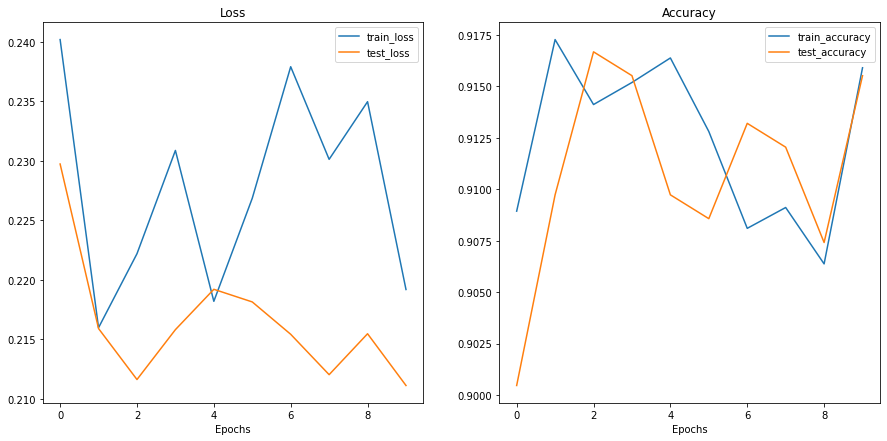

In [ ]:
# Plot loss curves 
utils.plot_loss_curves(augmix_results)

Due to the limits on the ordinate axis (loss values) there is not a large discrepancy in the loss of the training set compared to the test set, however, as can be seen in the values, both values are similar, although in the end a greater loss is observed in the training set.

The accuracy was greater than 91% in both sets (training and test).

In [ ]:
# Create Aug Mix statistics dictionary
augmix_stats = {"test_loss": augmix_results["test_loss"][-1],
                "test_acc": augmix_results["test_acc"][-1]}

augmix_stats

{'test_loss': 0.21111803604893525, 'test_acc': 0.9155092592592593}

# 4. Compare the results

To compare the results, we will put together all of the dictionaries with the statistics of each transformation in a DataFrame.

In [ ]:
import pandas as pd

# Turn stats dictionaries into DataFrame
stats = pd.DataFrame([no_aug_stats, colorjitter_stats, gaussblur_stats, randinv_stats,
                      randaug_stats, trivialaugmentwide_stats, augmix_stats])

# Add column for augmented name
stats["Augmentation"] = ["Control", "ColorJitter", "Gaussian Blur", "RandomInvert",
                         "RandomAugment", "TrivialAugmentWide", "AugMix"]

# Convert accuracy to percentages
stats["test_acc"] = round(stats["test_acc"]* 100, 2)

stats

,test_loss,test_acc,Augmentation
0,0.238930,90.05,Control
1,0.250036,89.70,ColorJitter
2,0.411950,84.61,Gaussian Blur
3,0.237306,90.28,RandomInvert
4,0.200314,91.90,RandomAugment
5,0.200503,92.36,TrivialAugmentWide
6,0.211118,91.55,AugMix


Sort the values to facilitate the visualization of the results.

In [ ]:
stats_sorted = stats.sort_values(by = "test_acc", ascending = True)
stats_sorted

,test_loss,test_acc,Augmentation
2,0.411950,84.61,Gaussian Blur
1,0.250036,89.70,ColorJitter
0,0.238930,90.05,Control
3,0.237306,90.28,RandomInvert
6,0.211118,91.55,AugMix
4,0.200314,91.90,RandomAugment
5,0.200503,92.36,TrivialAugmentWide


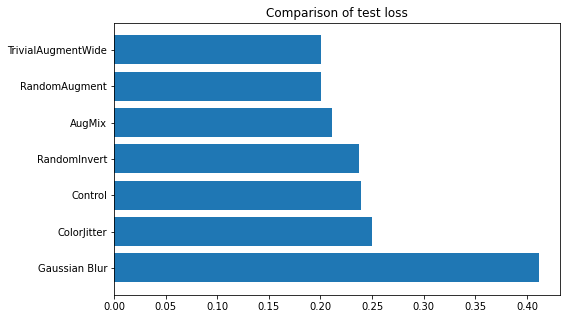

In [ ]:
# Plot the test loss
plt.figure(figsize = (8, 5))
plt.barh(y = stats_sorted.Augmentation, width = stats_sorted.test_loss)
plt.title("Comparison of test loss");

The transformation that obtained the lowest loss values for the test set is TrivialAugmentWide, followed by RandomAugment and AugMix in third place.

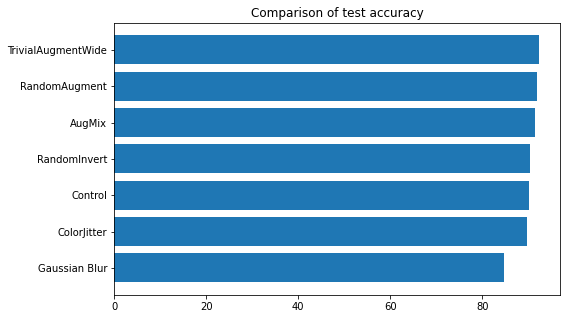

In [ ]:
# Plot the test accuracy
plt.figure(figsize = (8, 5))
plt.barh(y = stats_sorted.Augmentation, width = stats_sorted.test_acc)
plt.title("Comparison of test accuracy");

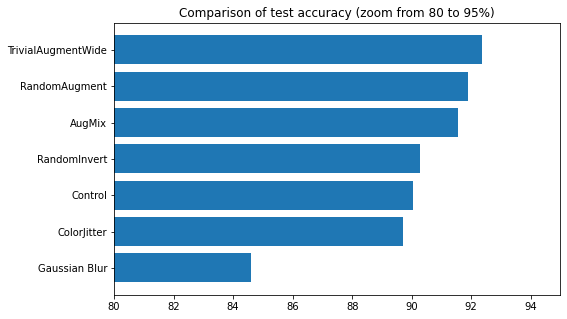

In [ ]:
# Plot the test accuracy, zoom to 80-95
plt.figure(figsize = (8, 5))
plt.barh(y = stats_sorted.Augmentation, width = stats_sorted.test_acc)
plt.xlim(80, 95)
plt.title("Comparison of test accuracy (zoom from 80 to 95%)");

The transformation that obtained the highest percentage of accuracy for the test set is TrivialAugmentWide, followed by RandomAugment and AugMix in third place.

In conclusion, the transformation with the best results (accuracy in the training set greater than 90%) was TrivialAugmentWide, followed by RandomAugment. 

These transformations change the colors of the images, helping the model to better discern between the different classes. 

Since the difference between Blight and Gray Leaf Spot is very small, like Common Rust, these transformations help the model to better discern between the different classes.